**Importing the Libraries required**

In [2]:
import json
import os
import time
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


**Installing *pennylane* for Quantum Computation and Machine Learning Applications**

In [3]:
!pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 108.7 MB/s eta 0:00:00


Importing the **pennylane** library

In [4]:
import pennylane as qml
from pennylane import numpy as pnp


Mounting the Drive to store the results generated in drive.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Given a simple classification task - Two approaches were tried in this experiment**


> *Classical ML Approach* - SVM with RBF Kernel & 3 Layer ANN.


> *Quantum ML Approach* - 4-qubit variational quantum circuit (PennyLane)


The **Iris Dataset** was used for this task. It has a total of 150 samples with three classes namely - *setosa , versicolor & viriginica*.

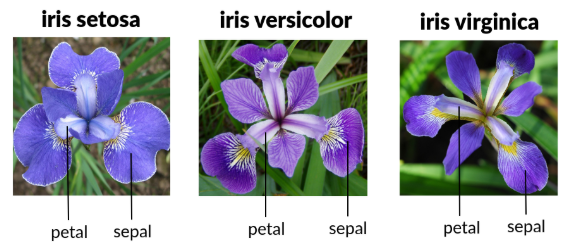


**Loading the Dataset and Creating the Train-Test Split**

In [9]:
# Configurations

RANDOM_SEED = 42
TEST_SIZE = 0.2

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

def load_data():
    iris = load_iris()
    X, y = iris.data, iris.target
    class_names = iris.target_names.tolist()

    # Stratified train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
    )

    # Standard scaling (fit on train, transform both)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"Dataset: Iris | Train: {len(X_train)} | Test: {len(X_test)} | Classes: {class_names}")
    return X_train_scaled, X_test_scaled, y_train, y_test, class_names

The Results obtained after running the Classical ML Model will be stored here. The location of the folder can be changed as per the convenience.

In [7]:
RESULTS_DIR = "/content/drive/MyDrive/iris_classical_results"

**Configurations and Hyperparameters**

In [8]:
NN_EPOCHS = 150
NN_LR = 0.01
NN_BATCH_SIZE = 16

**Classical ML Approach** - SVM with RBF Kernel and GridSearchCV for searching the best hyperparameters.

In [11]:
def train_svm(X_train, X_test, y_train, y_test, class_names):
    print("\n" + "=" * 60)
    print("MODEL 1: Support Vector Machine (RBF Kernel)")
    print("=" * 60)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf']
    }

    grid_search = GridSearchCV(
        SVC(random_state=RANDOM_SEED),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)

    best_svm = grid_search.best_estimator_
    print(f"Best params: {grid_search.best_params_}")
    print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

    # Predictions
    y_pred_train = best_svm.predict(X_train)
    y_pred_test = best_svm.predict(X_test)

    # Metrics
    results = compute_metrics(y_train, y_pred_train, y_test, y_pred_test, class_names, "SVM")
    results['best_params'] = {k: str(v) for k, v in grid_search.best_params_.items()}
    results['cv_accuracy'] = float(grid_search.best_score_)

    return results


**Classical ML Approach** - 3 Layer Artificial Neural Network (ANN)

In [12]:
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(4, 16),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        return self.network(x)


def train_neural_network(X_train, X_test, y_train, y_test, class_names):
    print("\n" + "=" * 60)
    print("MODEL 2: PyTorch Neural Network (4→16→8→3)")
    print("=" * 60)

    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.LongTensor(y_train)
    X_test_t = torch.FloatTensor(X_test)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=NN_BATCH_SIZE, shuffle=True)

    # Model, loss, optimizer
    model = IrisNet()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=NN_LR, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

    # Training loop
    train_losses = []
    train_accs = []

    for epoch in range(NN_EPOCHS):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        scheduler.step()
        avg_loss = epoch_loss / total
        acc = correct / total
        train_losses.append(avg_loss)
        train_accs.append(acc)

        if (epoch + 1) % 30 == 0:
            print(f"  Epoch {epoch+1:3d}/{NN_EPOCHS} | Loss: {avg_loss:.4f} | Train Acc: {acc:.4f}")

    # Evaluate
    model.eval()
    with torch.no_grad():
        y_pred_train = torch.argmax(model(X_train_t), dim=1).numpy()
        y_pred_test = torch.argmax(model(X_test_t), dim=1).numpy()

    results = compute_metrics(y_train, y_pred_train, y_test, y_pred_test, class_names, "Neural Network")
    results['epochs'] = NN_EPOCHS
    results['final_loss'] = float(train_losses[-1])
    results['training_curve'] = {
        'losses': [float(l) for l in train_losses],
        'accuracies': [float(a) for a in train_accs]
    }

    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(train_losses, linewidth=1.5)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Neural Network — Training Loss')
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_accs, linewidth=1.5)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Neural Network — Training Accuracy')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'nn_training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()

    return results


# Metrics & Visualization
def compute_metrics(y_train, y_pred_train, y_test, y_pred_test, class_names, model_name):
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='macro')
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    cm = confusion_matrix(y_test, y_pred_test)

    print(f"\n  Train Accuracy:  {train_acc:.4f}")
    print(f"  Test Accuracy:   {test_acc:.4f}")
    print(f"  Precision (macro): {precision:.4f}")
    print(f"  Recall (macro):    {recall:.4f}")
    print(f"  F1-score (macro):  {f1:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=class_names, digits=4))

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name} — Confusion Matrix')
    plt.tight_layout()

    fname = model_name.lower().replace(' ', '_')
    plt.savefig(os.path.join(RESULTS_DIR, f'{fname}_confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.close()

    return {
        'model_name': model_name,
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': cm.tolist()
    }


Running the **main** function to start the execution

In [13]:
def main():
    os.makedirs(RESULTS_DIR, exist_ok=True)
    print(f"📁 Saving results to: {RESULTS_DIR}")

    # Load data
    X_train, X_test, y_train, y_test, class_names = load_data()

    # Train SVM
    svm_results = train_svm(X_train, X_test, y_train, y_test, class_names)

    # Train Neural Network
    nn_results = train_neural_network(X_train, X_test, y_train, y_test, class_names)

    # Save results
    all_results = {
        'svm': svm_results,
        'neural_network': nn_results,
        'dataset': 'Iris',
        'train_size': len(y_train),
        'test_size': len(y_test),
        'random_seed': RANDOM_SEED,
        'class_names': class_names
    }

    results_path = os.path.join(RESULTS_DIR, 'classical_results.json')
    with open(results_path, 'w') as f:
        json.dump(all_results, f, indent=2)

    print(f"\nClassical results saved to {results_path}")
    return all_results


if __name__ == '__main__':
    main()

📁 Saving results to: /content/drive/MyDrive/iris_classical_results
Dataset: Iris | Train: 120 | Test: 30 | Classes: ['setosa', 'versicolor', 'virginica']

MODEL 1: Support Vector Machine (RBF Kernel)
Best params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best CV accuracy: 0.9833

  Train Accuracy:  0.9833
  Test Accuracy:   0.9667
  Precision (macro): 0.9697
  Recall (macro):    0.9667
  F1-score (macro):  0.9666

  Classification Report:
              precision    recall  f1-score   support

      setosa     1.0000    1.0000    1.0000        10
  versicolor     1.0000    0.9000    0.9474        10
   virginica     0.9091    1.0000    0.9524        10

    accuracy                         0.9667        30
   macro avg     0.9697    0.9667    0.9666        30
weighted avg     0.9697    0.9667    0.9666        30


MODEL 2: PyTorch Neural Network (4→16→8→3)
  Epoch  30/150 | Loss: 0.0764 | Train Acc: 0.9750
  Epoch  60/150 | Loss: 0.0449 | Train Acc: 0.9750
  Epoch  90/150 | Loss: 0.0471 |

## **These Plots were generated and then saved in the Drive**




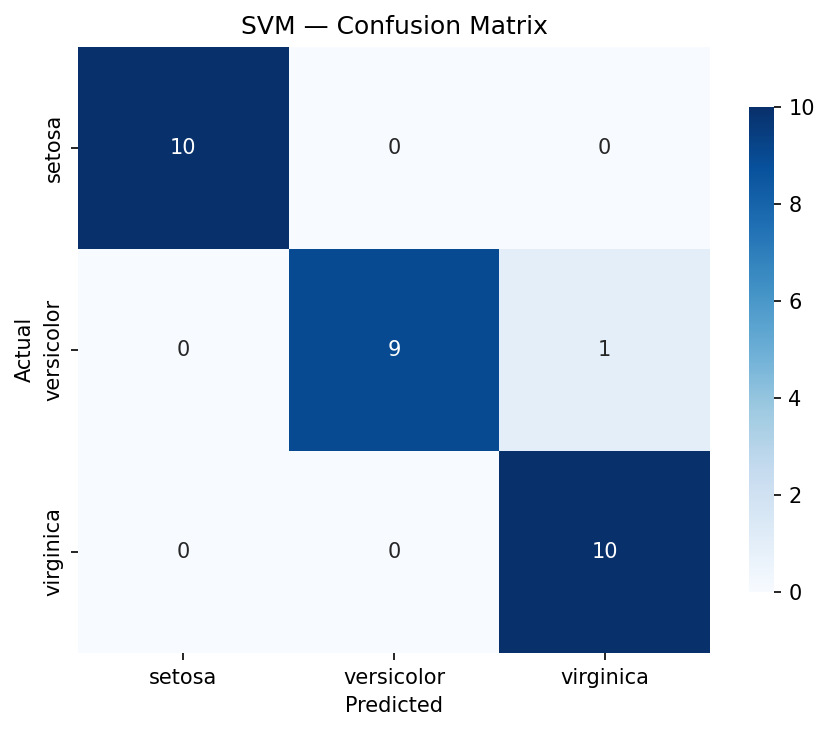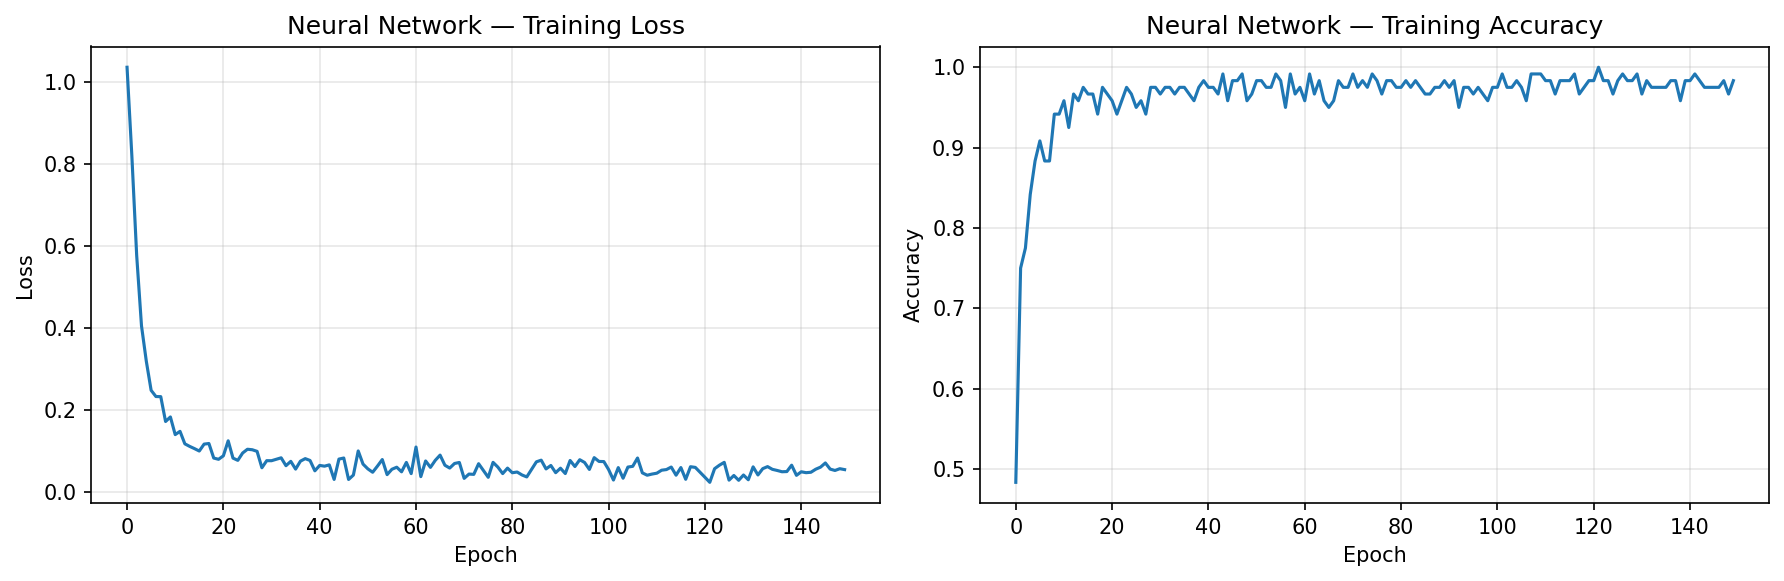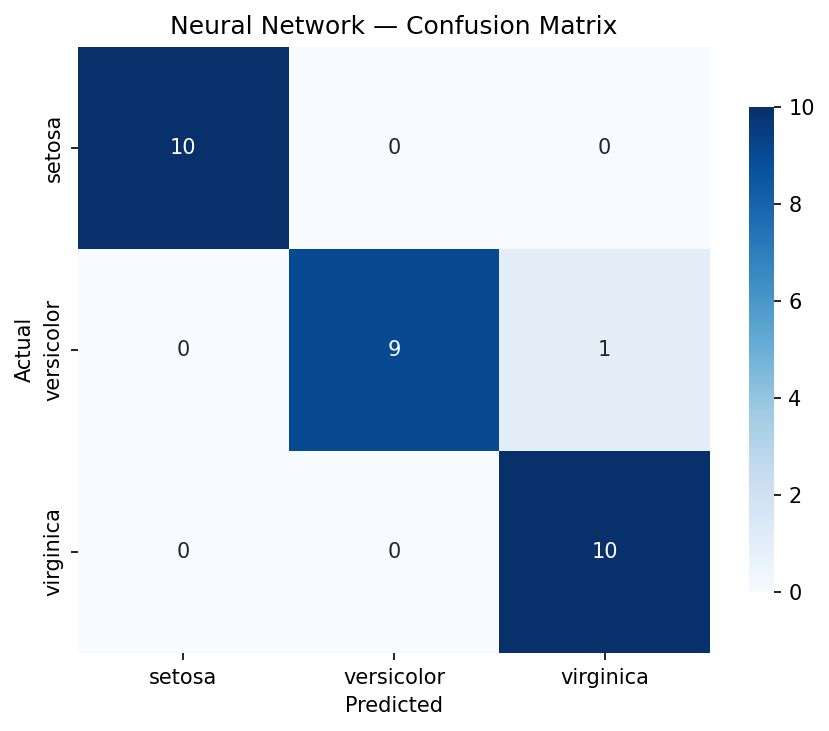

---

**Quantum Neural Network** - 4-qubit variational quantum circuit (VQC)



```
Features → [RX Encoding] → [RY/RZ Rotations + CNOT Entanglement] × 3 layers → [PauliZ Measurement] → Softmax → Class
```


*   4 qubits (one per Iris feature)
*   Angle embedding via RX gates
*   3 variational layers with RY, RZ rotations + ring-topology CNOT entanglement
*   24 trainable parameters
*   Trained with Adam optimizer, cross-entropy loss


Setting Up the Configuration and Hyperparameters

In [16]:
RANDOM_SEED = 42
TEST_SIZE = 0.2
N_QUBITS = 4
N_LAYERS = 3
N_EPOCHS = 80
LEARNING_RATE = 0.05
BATCH_SIZE = 10

The drive location for storing the results.

In [17]:
RESULTS_DIR = "/content/drive/MyDrive/iris_qnn_results"

**Preparing the Dataset**

In [18]:
def load_data():
    iris = load_iris()
    X, y = iris.data, iris.target
    class_names = iris.target_names.tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    angle_scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_angles = angle_scaler.fit_transform(X_train_scaled)
    X_test_angles = angle_scaler.transform(X_test_scaled)

    print(f"Dataset: Iris (QNN) | Train: {len(X_train)} | Test: {len(X_test)} | Classes: {class_names}")
    print(f"Qubits: {N_QUBITS} | Layers: {N_LAYERS} | Epochs: {N_EPOCHS}")
    return X_train_angles, X_test_angles, y_train, y_test, class_names

**The Quantum Circuit**

In [19]:
dev = qml.device("default.qubit", wires=N_QUBITS)


def variational_layer(weights, layer_idx):
    for qubit in range(N_QUBITS):
        qml.RY(weights[layer_idx, qubit, 0], wires=qubit)
        qml.RZ(weights[layer_idx, qubit, 1], wires=qubit)

    for qubit in range(N_QUBITS):
        qml.CNOT(wires=[qubit, (qubit + 1) % N_QUBITS])


@qml.qnode(dev, interface="autograd")
def quantum_circuit(features, weights):
    for qubit in range(N_QUBITS):
        qml.RX(features[qubit], wires=qubit)

    for layer in range(N_LAYERS):
        variational_layer(weights, layer)

    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

**Training and Modelling the QNN**

In [15]:
def softmax(x):
    e_x = pnp.exp(x - pnp.max(x))
    return e_x / pnp.sum(e_x)


def predict_proba(features, weights):
    expectations = quantum_circuit(features, weights)
    shifted = [(e + 1) / 2 for e in expectations]
    return softmax(pnp.array(shifted))


def predict(features, weights):
    probs = predict_proba(features, weights)
    return int(pnp.argmax(probs))


def cost(weights, X_batch, y_batch):
    total_loss = 0.0
    for x, y_true in zip(X_batch, y_batch):
        probs = predict_proba(x, weights)
        total_loss += -pnp.log(probs[y_true] + 1e-8)
    return total_loss / len(X_batch)


# train Loop
def train_qnn(X_train, X_test, y_train, y_test, class_names):
    print("\n" + "=" * 60)
    print("QNN: Variational Quantum Classifier (PennyLane)")
    print("=" * 60)

    weights = pnp.random.uniform(
        0, 2 * np.pi,
        size=(N_LAYERS, N_QUBITS, 2),
        requires_grad=True
    )

    n_params = N_LAYERS * N_QUBITS * 2
    print(f"  Trainable parameters: {n_params}")
    print(f"  Circuit depth: {N_LAYERS} variational layers")

    opt = qml.AdamOptimizer(stepsize=LEARNING_RATE)

    train_losses = []
    train_accs = []
    test_accs = []
    acc_epochs = []

    start_time = time.time()

    for epoch in range(N_EPOCHS):
        perm = np.random.permutation(len(X_train))
        X_shuffled = X_train[perm]
        y_shuffled = y_train[perm]

        epoch_loss = 0.0
        n_batches = 0

        for i in range(0, len(X_train), BATCH_SIZE):
            X_batch = X_shuffled[i:i+BATCH_SIZE]
            y_batch = y_shuffled[i:i+BATCH_SIZE]

            weights, batch_loss = opt.step_and_cost(
                lambda w: cost(w, X_batch, y_batch),
                weights
            )
            epoch_loss += float(batch_loss)
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            train_preds = np.array([predict(x, weights) for x in X_train])
            test_preds = np.array([predict(x, weights) for x in X_test])

            t_acc = accuracy_score(y_train, train_preds)
            te_acc = accuracy_score(y_test, test_preds)

            train_accs.append(t_acc)
            test_accs.append(te_acc)
            acc_epochs.append(epoch + 1)

            elapsed = time.time() - start_time
            print(f"  Epoch {epoch+1:3d}/{N_EPOCHS} | Loss: {avg_loss:.4f} | "
                  f"Train Acc: {t_acc:.4f} | Test Acc: {te_acc:.4f} | "
                  f"Time: {elapsed:.1f}s")

    total_time = time.time() - start_time
    print(f"\n  Total training time: {total_time:.1f}s")

    y_pred_train = np.array([predict(x, weights) for x in X_train])
    y_pred_test = np.array([predict(x, weights) for x in X_test])

    results = compute_metrics(y_train, y_pred_train, y_test, y_pred_test, class_names)
    results['n_qubits'] = N_QUBITS
    results['n_layers'] = N_LAYERS
    results['n_params'] = n_params
    results['epochs'] = N_EPOCHS
    results['training_time_seconds'] = round(total_time, 2)
    results['training_curve'] = {
        'losses': [float(l) for l in train_losses],
        'train_accuracies': [float(a) for a in train_accs],
        'test_accuracies': [float(a) for a in test_accs],
        'acc_epochs': acc_epochs
    }

    plot_training_curves(train_losses, train_accs, test_accs, acc_epochs)

    print("\n  Quantum Circuit Diagram:")
    sample = X_train[0]
    print(qml.draw(quantum_circuit)(sample, weights))

    return results

def compute_metrics(y_train, y_pred_train, y_test, y_pred_test, class_names):
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test, average='macro')
    recall = recall_score(y_test, y_pred_test, average='macro')
    f1 = f1_score(y_test, y_pred_test, average='macro')
    cm = confusion_matrix(y_test, y_pred_test)

    print(f"\n  Train Accuracy:    {train_acc:.4f}")
    print(f"  Test Accuracy:     {test_acc:.4f}")
    print(f"  Precision (macro): {precision:.4f}")
    print(f"  Recall (macro):    {recall:.4f}")
    print(f"  F1-score (macro):  {f1:.4f}")
    print(f"\n  Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=class_names, digits=4))

    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
                xticklabels=class_names, yticklabels=class_names,
                ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('QNN Variational Classifier — Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'qnn_confusion_matrix.png'), dpi=150, bbox_inches='tight')
    plt.close()

    return {
        'model_name': 'QNN (Variational Quantum Classifier)',
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'confusion_matrix': cm.tolist()
    }


def plot_training_curves(losses, train_accs, test_accs, acc_epochs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

    ax1.plot(range(1, len(losses) + 1), losses, linewidth=1.5, alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Cross-Entropy Loss')
    ax1.set_title('QNN — Training Loss')
    ax1.grid(True, alpha=0.3)

    ax2.plot(acc_epochs, train_accs, 'o-', linewidth=1.5, markersize=4, label='Train')
    ax2.plot(acc_epochs, test_accs, 's-', linewidth=1.5, markersize=4, label='Test')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('QNN — Accuracy over Training')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'qnn_training_curves.png'), dpi=150, bbox_inches='tight')
    plt.close()


---

In [20]:
def main():
    np.random.seed(RANDOM_SEED)
    os.makedirs(RESULTS_DIR, exist_ok=True)
    print(f"📁 Saving QNN results to: {RESULTS_DIR}")

    X_train, X_test, y_train, y_test, class_names = load_data()
    qnn_results = train_qnn(X_train, X_test, y_train, y_test, class_names)

    all_results = {
        'qnn': qnn_results,
        'dataset': 'Iris',
        'train_size': len(y_train),
        'test_size': len(y_test),
        'random_seed': RANDOM_SEED,
        'class_names': class_names
    }

    results_path = os.path.join(RESULTS_DIR, 'qnn_results.json')
    with open(results_path, 'w') as f:
        json.dump(all_results, f, indent=2)

    print(f"\nQNN results saved to {results_path}")
    return all_results


if __name__ == '__main__':
    main()

📁 Saving QNN results to: /content/drive/MyDrive/iris_qnn_results
Dataset: Iris (QNN) | Train: 120 | Test: 30 | Classes: ['setosa', 'versicolor', 'virginica']
Qubits: 4 | Layers: 3 | Epochs: 80

QNN: Variational Quantum Classifier (PennyLane)
  Trainable parameters: 24
  Circuit depth: 3 variational layers
  Epoch   1/80 | Loss: 1.0104 | Train Acc: 0.7750 | Test Acc: 0.7667 | Time: 7.3s
  Epoch   5/80 | Loss: 0.8510 | Train Acc: 0.8750 | Test Acc: 0.9000 | Time: 31.3s
  Epoch  10/80 | Loss: 0.8138 | Train Acc: 0.8917 | Test Acc: 0.9000 | Time: 55.5s
  Epoch  15/80 | Loss: 0.7887 | Train Acc: 0.9083 | Test Acc: 0.8000 | Time: 82.2s
  Epoch  20/80 | Loss: 0.7876 | Train Acc: 0.9083 | Test Acc: 0.8333 | Time: 106.9s
  Epoch  25/80 | Loss: 0.7885 | Train Acc: 0.9167 | Test Acc: 0.8333 | Time: 132.7s
  Epoch  30/80 | Loss: 0.7877 | Train Acc: 0.8833 | Test Acc: 0.8333 | Time: 158.8s
  Epoch  35/80 | Loss: 0.7875 | Train Acc: 0.8833 | Test Acc: 0.8333 | Time: 183.4s
  Epoch  40/80 | Loss: 0.7

## **Results for the QNN**

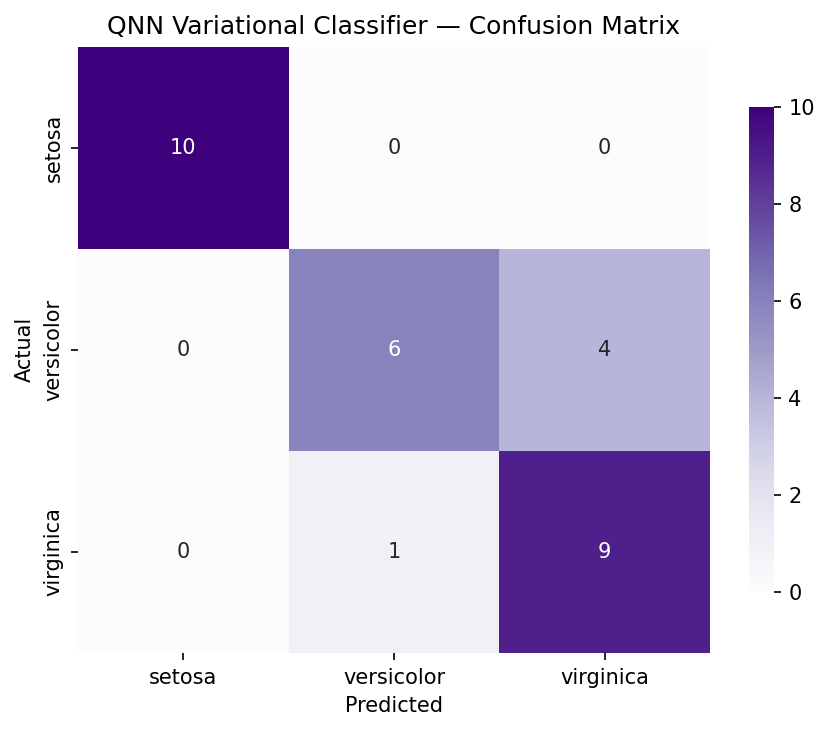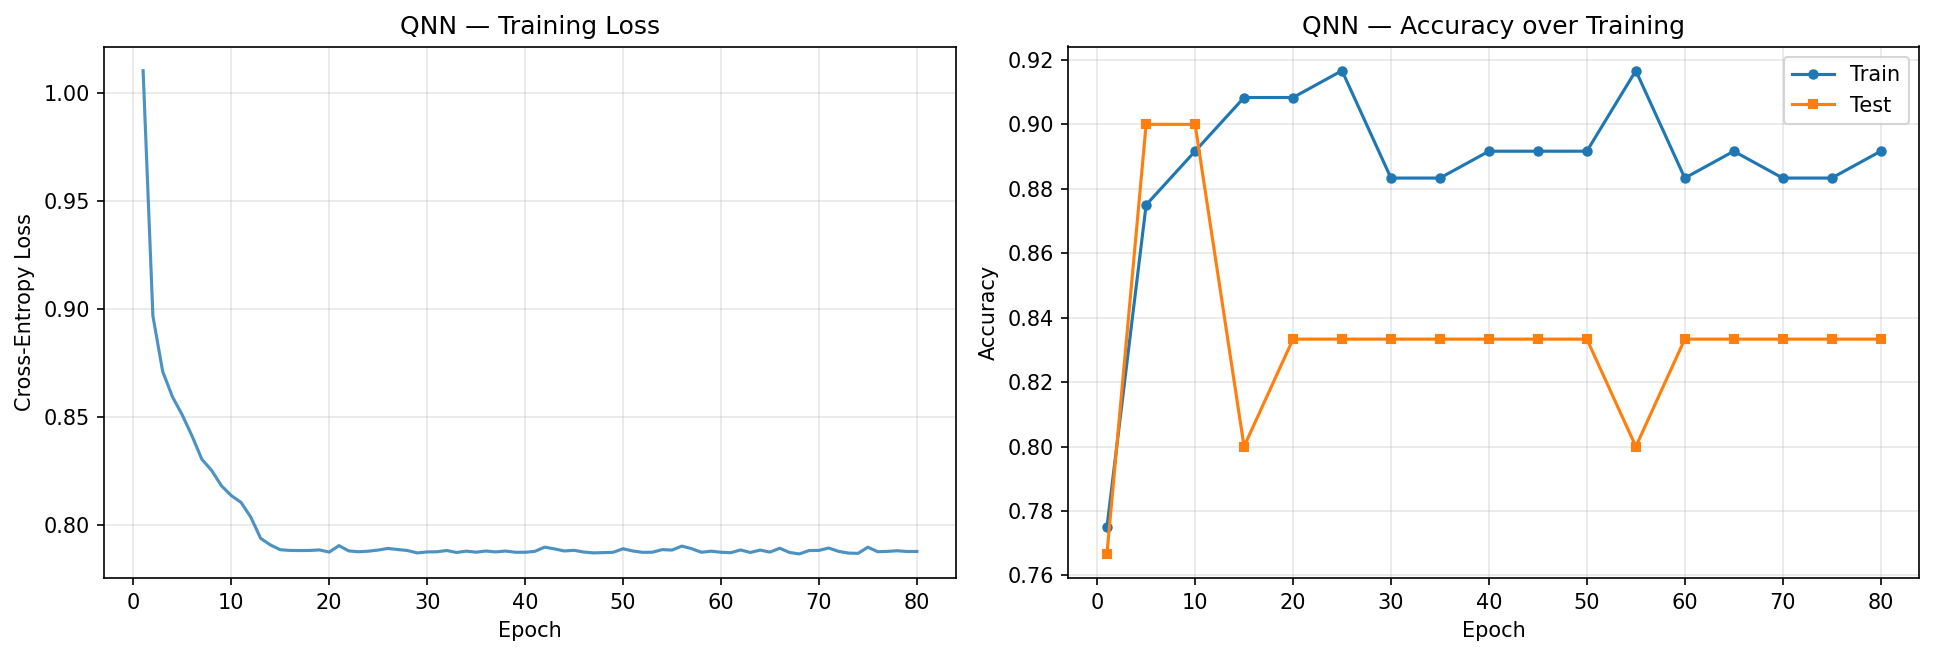

---